In [1]:
import os

N_THREADS = "4"
os.environ["OMP_NUM_THREADS"] = N_THREADS
os.environ["OPENBLAS_NUM_THREADS"] = N_THREADS
os.environ["MKL_NUM_THREADS"] = N_THREADS
os.environ["VECLIB_MAXIMUM_THREADS"] = N_THREADS
os.environ["NUMEXPR_NUM_THREADS"] = N_THREADS

In [2]:
import gEconpy as ge
import numpy as np
import pandas as pd
import gEconpy.plotting as gp
import matplotlib.pyplot as plt

In [3]:
mod = ge.model_from_gcn("../GCN Files/sims_2024/nk_taylor_rule_fully_linear.gcn")

Model Building Complete.
Found:
	9 equations
	9 variables
	3 stochastic shocks
		 0 / 3 has a defined prior. 
	9 parameters
		 9 / 9 parameters has a defined prior. 
	0 parameters to calibrate.
Model appears well defined and ready to proceed to solving.



In [4]:
mod.steady_state()

{'A_ss': 0.0,
 'N_ss': 0.0,
 'Y_ss': 0.0,
 'cost_push_shock_ss': 0.0,
 'i_ss': 0.0,
 'interest_shock_ss': 0.0,
 'mc_ss': 0.0,
 'pi_ss': 0.0,
 'w_ss': 0.0}

In [5]:
mod.parameters()

{'beta': 0.99,
 'chi': 1.0,
 'phi': 0.75,
 'phi_Y': 0.5,
 'phi_pi': 1.5,
 'rho_A': 0.9,
 'rho_i': 0.5,
 'rho_markup': 0.8,
 'sigma': 3.0}

In [6]:
irf_params = {
    "beta": 0.99,
    "sigma": 3.0,
    "chi": 1,
    "phi": 3 / 4,
    "rho_A": 0.9,
    "rho_i": 0.5,
    "phi_pi": 1.5,
    "phi_Y": 0.5,
}
irf = ge.impulse_response_function(
    mod,
    **irf_params,
    shock_size={"epsilon_A": 0.01, "epsilon_interest": 0.01},
    simulation_length=20,
    log_linearize=False,
)

Solution found, sum of squared residuals: 0.000000000
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


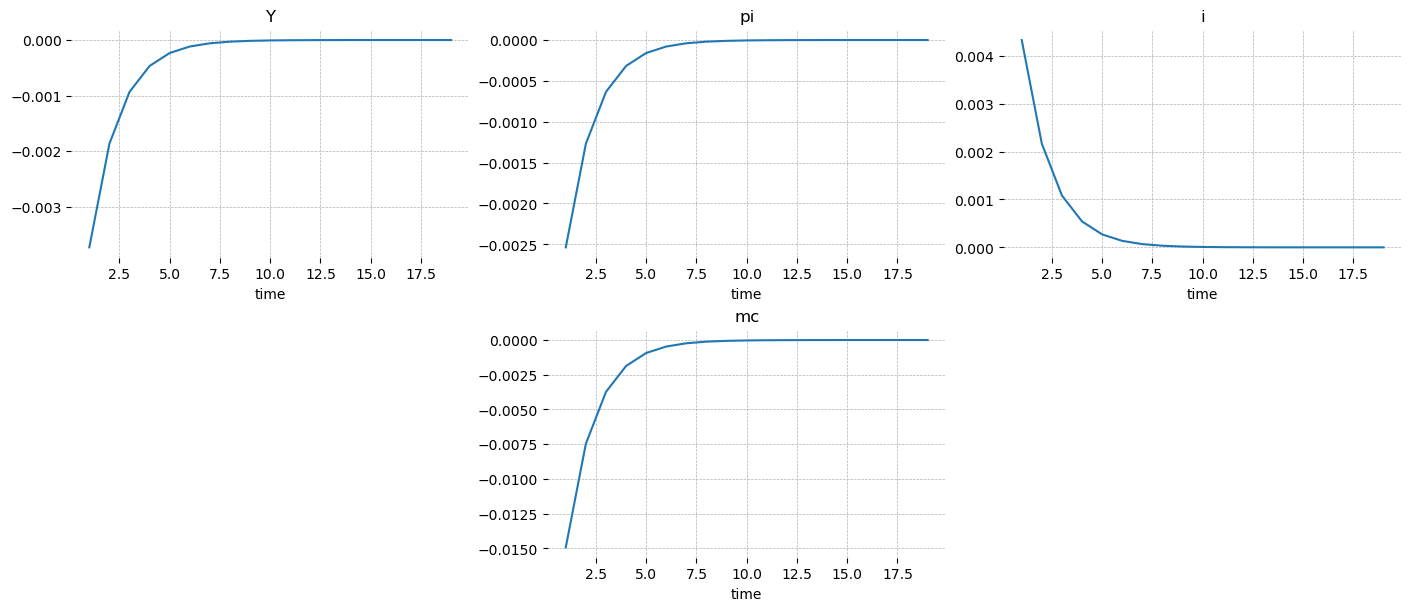

In [7]:
import gEconpy.plotting as gp

gp.plot_irf(
    irf.isel(time=slice(1, None)),
    vars_to_plot=["Y", "pi", "i", "mc"],
    shocks_to_plot=["epsilon_interest"],
    n_cols=3,
    figsize=(14, 6),
);

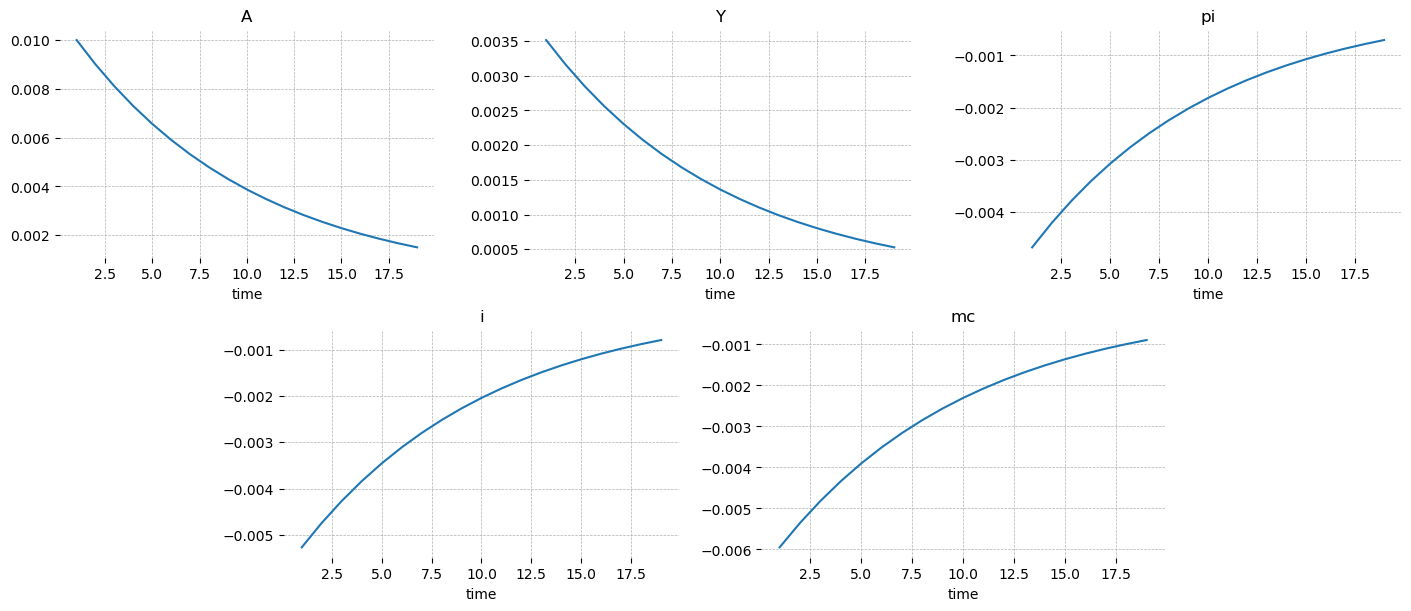

In [8]:
gp.plot_irf(
    irf.isel(time=slice(1, None)),
    vars_to_plot=["A", "Y", "pi", "i", "mc"],
    shocks_to_plot=["epsilon_A"],
    n_cols=3,
    figsize=(14, 6),
);

In [13]:
irf_by_phi = {
    f"phi = {phi}": ge.impulse_response_function(
        mod,
        **(irf_params | {"phi": phi}),
        shock_size={"epsilon_A": 0.01, "epsilon_interest": 0.01},
        simulation_length=20,
        log_linearize=False,
        verbose=False,
    ).isel(time=slice(1, None))
    for phi in [0.1, 0.75, 0.9]
}

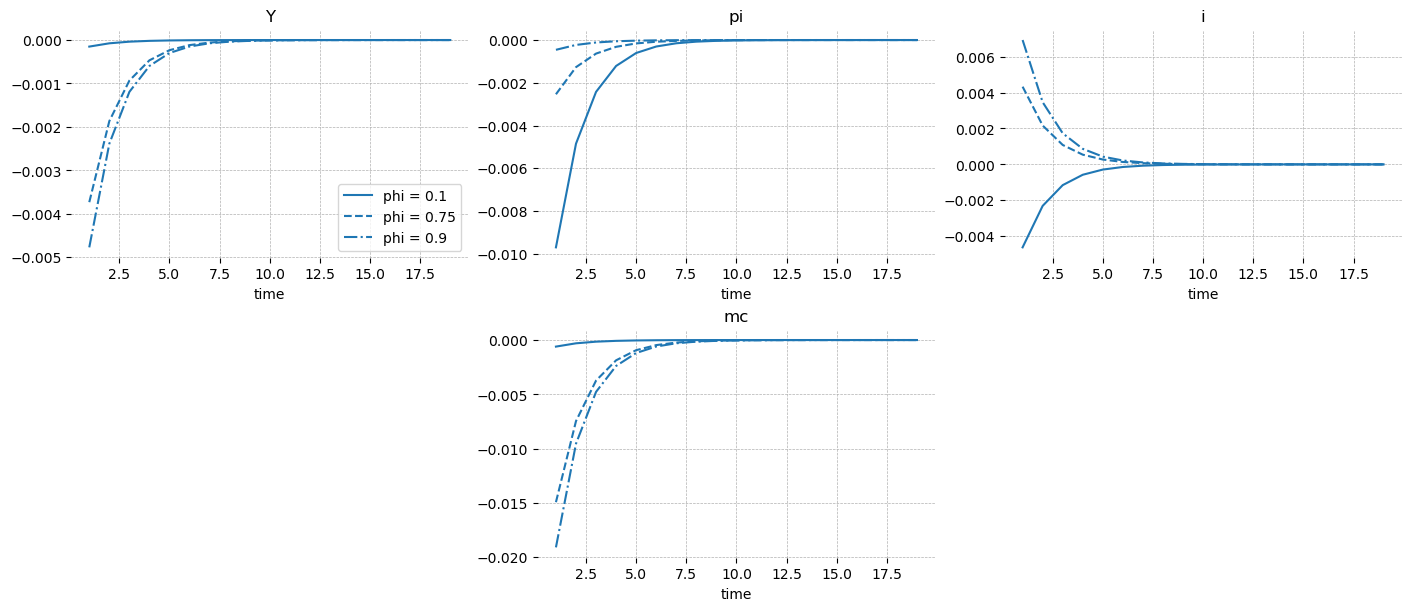

In [14]:
gp.plot_irf(
    irf_by_phi,
    vars_to_plot=["Y", "pi", "i", "mc"],
    shocks_to_plot=["epsilon_interest"],
    n_cols=3,
    figsize=(14, 6),
);

The following variables had steady-state values close to zero and will not be log-linearized:['A_t', 'N_t', 'Y_t', 'cost_push_shock_t', 'i_t', 'interest_shock_t', 'mc_t', 'pi_t', 'w_t']
Solution found, sum of squared residuals: 0.000000000
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


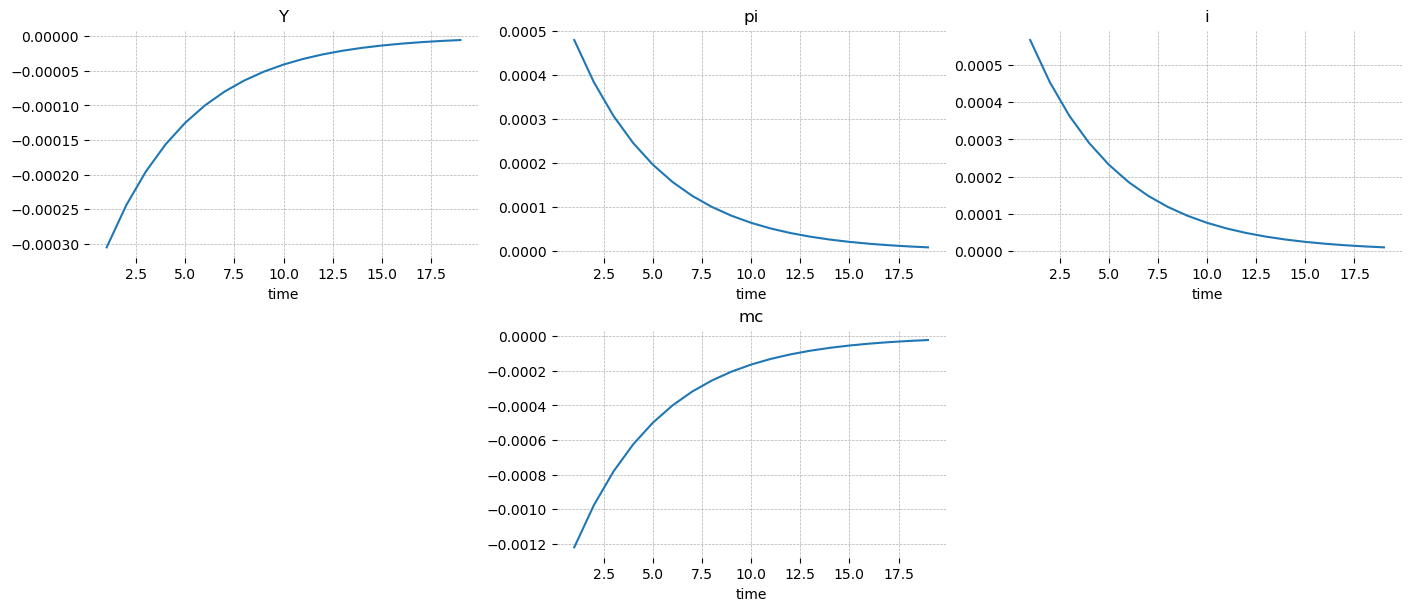

In [15]:
irf = ge.impulse_response_function(
    mod,
    phi=0.1,
    shock_size={"epsilon_markup": 0.01},
    simulation_length=20,
    log_linearize=True,
)
gp.plot_irf(
    irf.isel(time=slice(1, None)),
    vars_to_plot=["Y", "pi", "i", "mc"],
    shocks_to_plot=["epsilon_markup"],
    n_cols=3,
    figsize=(14, 6),
);

In [16]:
T, R = mod.solve_model(log_linearize=False)

Solution found, sum of squared residuals: 0.000000000
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


In [17]:
ge.matrix_to_dataframe(T, mod).round(3)

,A,N,Y,cost_push_shock,i,interest_shock,mc,pi,w
A,0.900,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0
N,-0.584,0.0,0.0,-1.194,0.0,-0.187,0.0,0.0,0.0
Y,0.316,0.0,0.0,-1.194,0.0,-0.187,0.0,0.0,0.0
cost_push_shock,0.000,-0.0,-0.0,0.800,-0.0,0.000,-0.0,-0.0,-0.0
i,-0.474,0.0,0.0,2.217,0.0,0.216,0.0,0.0,0.0
interest_shock,0.000,0.0,0.0,0.000,0.0,0.500,0.0,0.0,0.0
mc,-0.535,-0.0,-0.0,-4.775,-0.0,-0.746,-0.0,-0.0,-0.0
pi,-0.422,0.0,0.0,1.876,0.0,-0.127,0.0,0.0,0.0
w,0.365,-0.0,-0.0,-4.775,-0.0,-0.746,-0.0,-0.0,-0.0


In [18]:
ge.matrix_to_dataframe(R, mod).round(3)

,epsilon_A,epsilon_interest,epsilon_markup
A,1.000,0.000,0.000
N,-0.649,-0.373,-1.492
Y,0.351,-0.373,-1.492
cost_push_shock,-0.000,0.000,1.000
i,-0.527,0.433,2.771
interest_shock,0.000,1.000,0.000
mc,-0.595,-1.493,-5.968
pi,-0.468,-0.254,2.345
w,0.405,-1.493,-5.968


In [19]:
ss_mod = ge.statespace_from_gcn(
    "../GCN Files/sims_2024/nk_taylor_rule_fully_linear.gcn"
)

Model Building Complete.
Found:
	9 equations
	9 variables
	3 stochastic shocks
		 0 / 3 has a defined prior. 
	9 parameters
		 9 / 9 parameters has a defined prior. 
	0 parameters to calibrate.
Model appears well defined and ready to proceed to solving.

Statespace model construction complete, but call the .configure method to finalize.


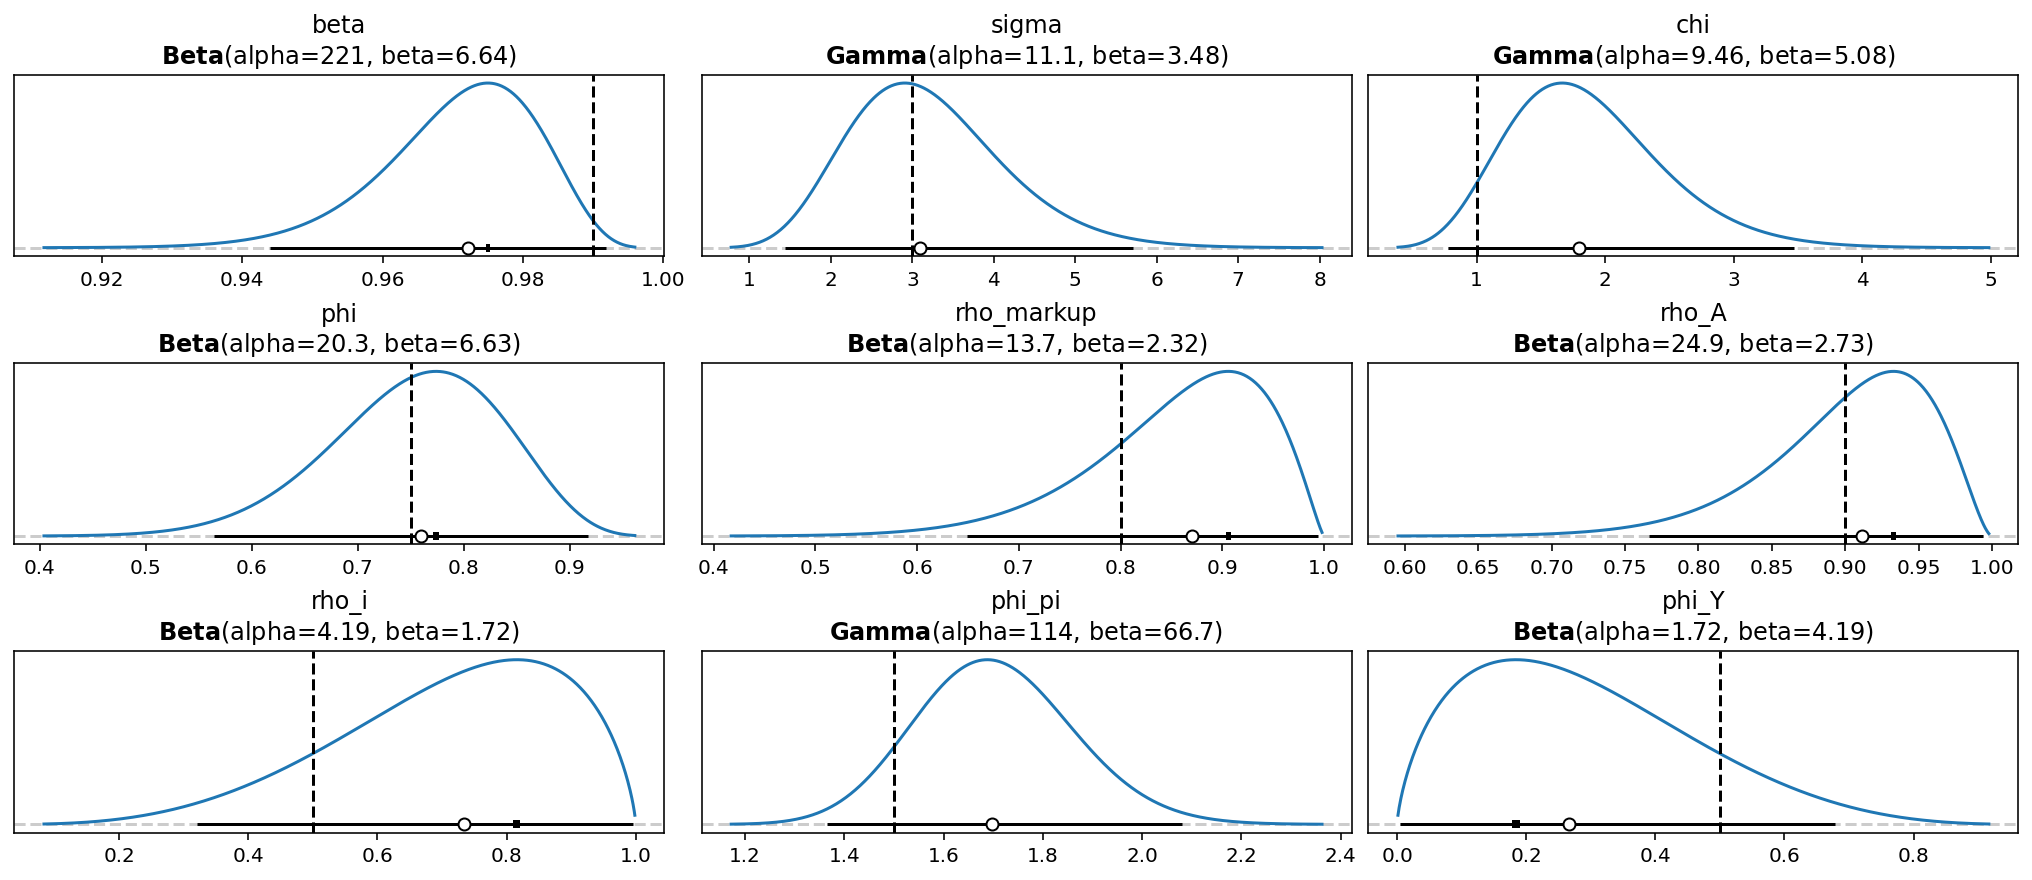

In [20]:
gp.plot_priors(ss_mod, n_cols=3);

In [23]:
ss_mod.configure(
    observed_states=["Y", "N", "pi", "i", "w"],
    measurement_error=["Y", "N", "w"],
    full_shock_covaraince=True,
    solver="scan_cycle_reduction",
    mode="JAX",
    max_iter=20,
    use_adjoint_gradients=True,
)

The following parameters should be assigned priors inside a PyMC model block: 
	beta -- shape: (), constraints: None, dims: None
	chi -- shape: (), constraints: None, dims: None
	phi -- shape: (), constraints: None, dims: None
	phi_Y -- shape: (), constraints: None, dims: None
	phi_pi -- shape: (), constraints: None, dims: None
	rho_A -- shape: (), constraints: None, dims: None
	rho_i -- shape: (), constraints: None, dims: None
	rho_markup -- shape: (), constraints: None, dims: None
	sigma -- shape: (), constraints: Positive, dims: None
	state_cov -- shape: (3, 3), constraints: Positive Semi-Definite, dims: ('shock', 'shock_aux')
	error_sigma_Y -- shape: (), constraints: None, dims: None
	error_sigma_N -- shape: (), constraints: None, dims: None
	error_sigma_w -- shape: (), constraints: None, dims: None


In [24]:
import pymc as pm
import preliz as pz

dates = pd.date_range(start="1980-01-01", end="2024-11-01", freq="QS-OCT")
dummy_data = pd.DataFrame(np.nan, index=dates, columns=ss_mod.observed_states)

all_priors = ss_mod.param_priors | ss_mod.shock_priors

with pm.Model(coords=ss_mod.coords) as pm_mod:
    ss_mod.to_pymc()
    for var_name in ss_mod.error_states:
        x = pz.maxent(pz.Gamma(), lower=0.01, upper=0.05, plot=False)
        all_priors[f"error_sigma_{var_name}"] = x
        x.to_pymc(name=f"error_sigma_{var_name}")

    chol, *_ = pm.LKJCholeskyCov(
        "state_chol", n=3, eta=6, sd_dist=pm.HalfNormal.dist(sigma=0.05)
    )
    cov = pm.Deterministic("state_cov", chol @ chol.T, dims=["shock", "shock_aux"])

    ss_mod.build_statespace_graph(
        dummy_data,
        add_bk_check=False,
        add_solver_success_check=True,
        add_norm_check=True,
        add_steady_state_penalty=True,
    )

    prior = pm.sample_prior_predictive()

/Users/jessegrabowski/mambaforge/envs/grabowski_phd/lib/python3.12/site-packages/pymc_extras/statespace/utils/data_tools.py:159: ImputationWarning: Provided data contains missing values and will be automatically imputed as hidden states during Kalman filtering.
  warnings.warn(impute_message, ImputationWarning)
/var/folders/7b/rzxy96cj0w751_6td3g2yss00000gn/T/ipykernel_74139/758441464.py:28: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  prior = pm.sample_prior_predictive()
Sampling: [beta, chi, error_sigma_N, error_sigma_Y, error_sigma_w, obs, phi, phi_Y, phi_pi, rho_A, rho_i, rho_markup, sigma, state_chol]


In [25]:
prior_trajectories = ss_mod.sample_unconditional_prior(prior)

/Users/jessegrabowski/mambaforge/envs/grabowski_phd/lib/python3.12/site-packages/pytensor/link/jax/linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x343CCC9E0>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [prior_combined]


Output()

In [26]:
idx = np.random.choice(prior.prior.coords["draw"].values)

true_params = prior.prior.isel(chain=0, draw=idx)
data = prior_trajectories.isel(chain=0, draw=idx).prior_observed
data = (
    data.to_dataframe()
    .drop(columns=["chain", "draw"])
    .unstack("observed_state")
    .droplevel(axis=1, level=0)
)

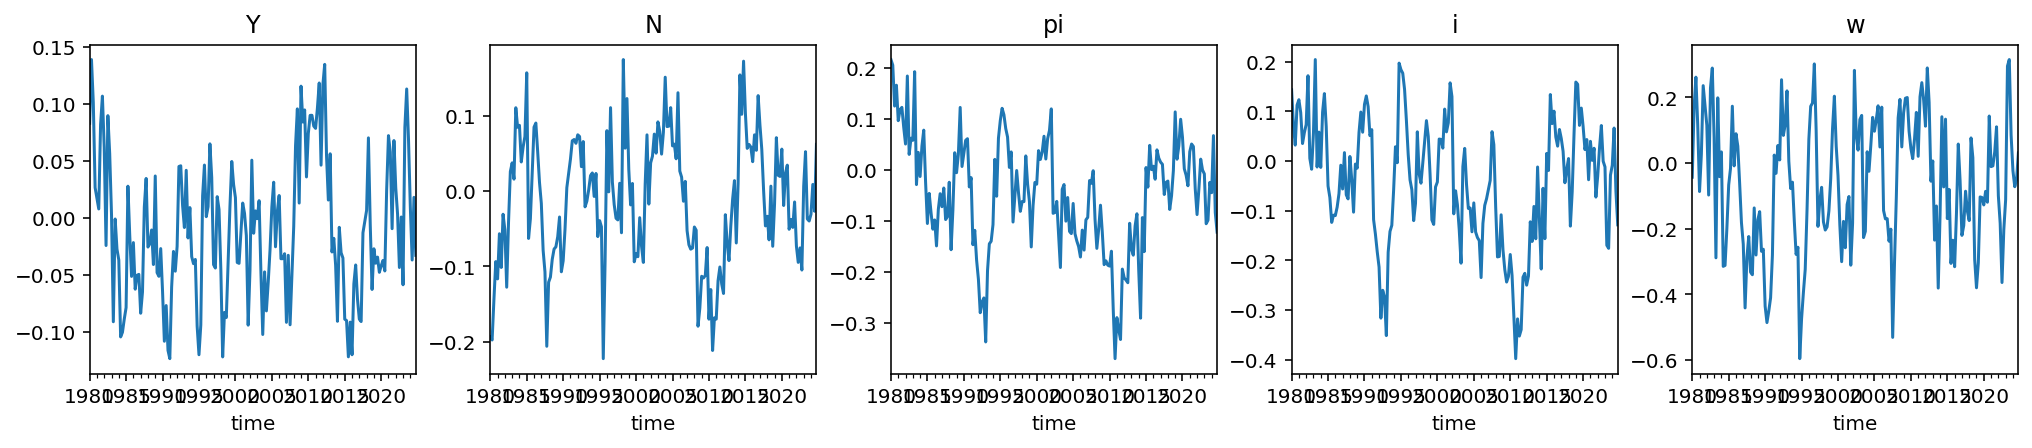

In [29]:
fig = plt.figure(figsize=(14, 3), dpi=144, layout="constrained")
gs, locs = gp.prepare_gridspec_figure(
    n_plots=len(ss_mod.observed_states), n_cols=5, figure=fig
)
for loc, col in zip(locs, data):
    axis = fig.add_subplot(gs[loc])
    data[col].plot(ax=axis, legend=False, title=col)

In [30]:
with pm_mod:
    pm.set_data({"data": data})
    ss_mod._fit_data = data

In [44]:
from pymc.model.transform.optimization import freeze_dims_and_data
import nutpie as ntp

ntp_mod = ntp.compile_pymc_model(
    freeze_dims_and_data(pm_mod),
    backend="jax",
    gradient_backend="jax",
    default_initialization_strategy="support_point",
    jitter_rvs=None,
    initial_points=None,
)

In [45]:
idata = ntp.sample(
    ntp_mod.with_transform_adapt(
        verbose=True,
        learning_rate=1e-3,
        num_layers=3,
        batch_size=256,
        initial_skip=256,
        zero_init=False,
        dct_layer=True,
        extend_dct=True,
    ),
    tune=1000,
    draws=1000,
    chains=6,
    transform_adapt=True,
)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,37,0.39,7
,2000,0,0.72,7
,2000,0,0.70,3
,2000,0,0.72,7
,2000,0,0.69,7
,2000,1,0.72,7


Chain 4: Total available points: 11
loss from diag: 5.167199433466604
Chain 5: Total available points: 11
loss from diag: 5.437317300655212
Chain 3: Total available points: 11
loss from diag: 6.783552756567594
Chain 0: Total available points: 11
loss from diag: 4.779334795465232
Chain 1: Total available points: 11
loss from diag: 5.368887046393058
Chain 2: Total available points: 11
loss from diag: 7.468471956662008
Chain 3: Total available points: 21
loss from diag: 3.276601468166167
Chain 0: Total available points: 21
loss from diag: -0.37725996020729774
Chain 1: Total available points: 21
loss from diag: 1.4022852173943778
Chain 4: Total available points: 21
loss from diag: -0.44514225205887986
Chain 5: Total available points: 21
loss from diag: 0.3038978096729137
Chain 0: Total available points: 31
loss from diag: 3.1549960891624327
Chain 2: Total available points: 21
loss from diag: -4.4025991786858265
Chain 5: Total available points: 31
loss from diag: 2.4379186973965226
Chain 0:

Chain 0: New loss 2.3118984207487903, old loss 2.6300979657488686
Chain 3: Total available points: 351
Chain 5: New loss -0.3353797763385497, old loss 0.3884408269901449
Chain 4: New loss -0.7179432596223457, old loss 1.4772735852395262
Chain 3: New loss -0.00843957638879487, old loss 2.220454481140668
Chain 2: Total available points: 501
Chain 1: Total available points: 501
Chain 2: New loss 0.10948274727363476, old loss 0.5046803652204365
Chain 5: Total available points: 501
Chain 1: New loss -0.3862844773946175, old loss 0.7978857127212883
Chain 4: Total available points: 451
Chain 5: New loss 0.2807355952985734, old loss 0.46349241040414635
Chain 3: Total available points: 401
Extending flow...
0.4189482940488866 [0.14802643 0.07354211 0.08127615 0.13729791 0.13985922 0.11300944
 0.20409081 0.20665222 0.38820678 0.06561533 0.04049705 0.11779015
 0.03470147 0.14362419 0.41894829 0.07974011 0.16480648 0.26767875]
dct: False
Chain 4: New loss -0.21552682332463383, old loss 0.346906203

Chain 4: New loss -1.22517527589221, old loss -1.0417688138718229
Chain 3: New loss -1.1341349644773173, old loss -0.8396867561941264
Chain 0: New loss 2.4533678858316192, old loss 2.5185090329505684
Chain 3: Total available points: 801
Extending flow...
0.021525557442732667 [0.01300529 0.01336436 0.01775244 0.01721282 0.01981717 0.01145207
 0.02000889 0.01038005 0.01620122 0.0110842  0.01265112 0.01164789
 0.01043591 0.02152556 0.01306251 0.01386249 0.01783986 0.02009813]
dct: False
Chain 1: New loss -2.000528707920156, old loss -0.69440579654614
Chain 3: New loss -1.8149272801522474, old loss -0.902632588797147
Chain 3: Total available points: 851
Chain 3: New loss -1.8323614030801454, old loss -1.6856374344529135


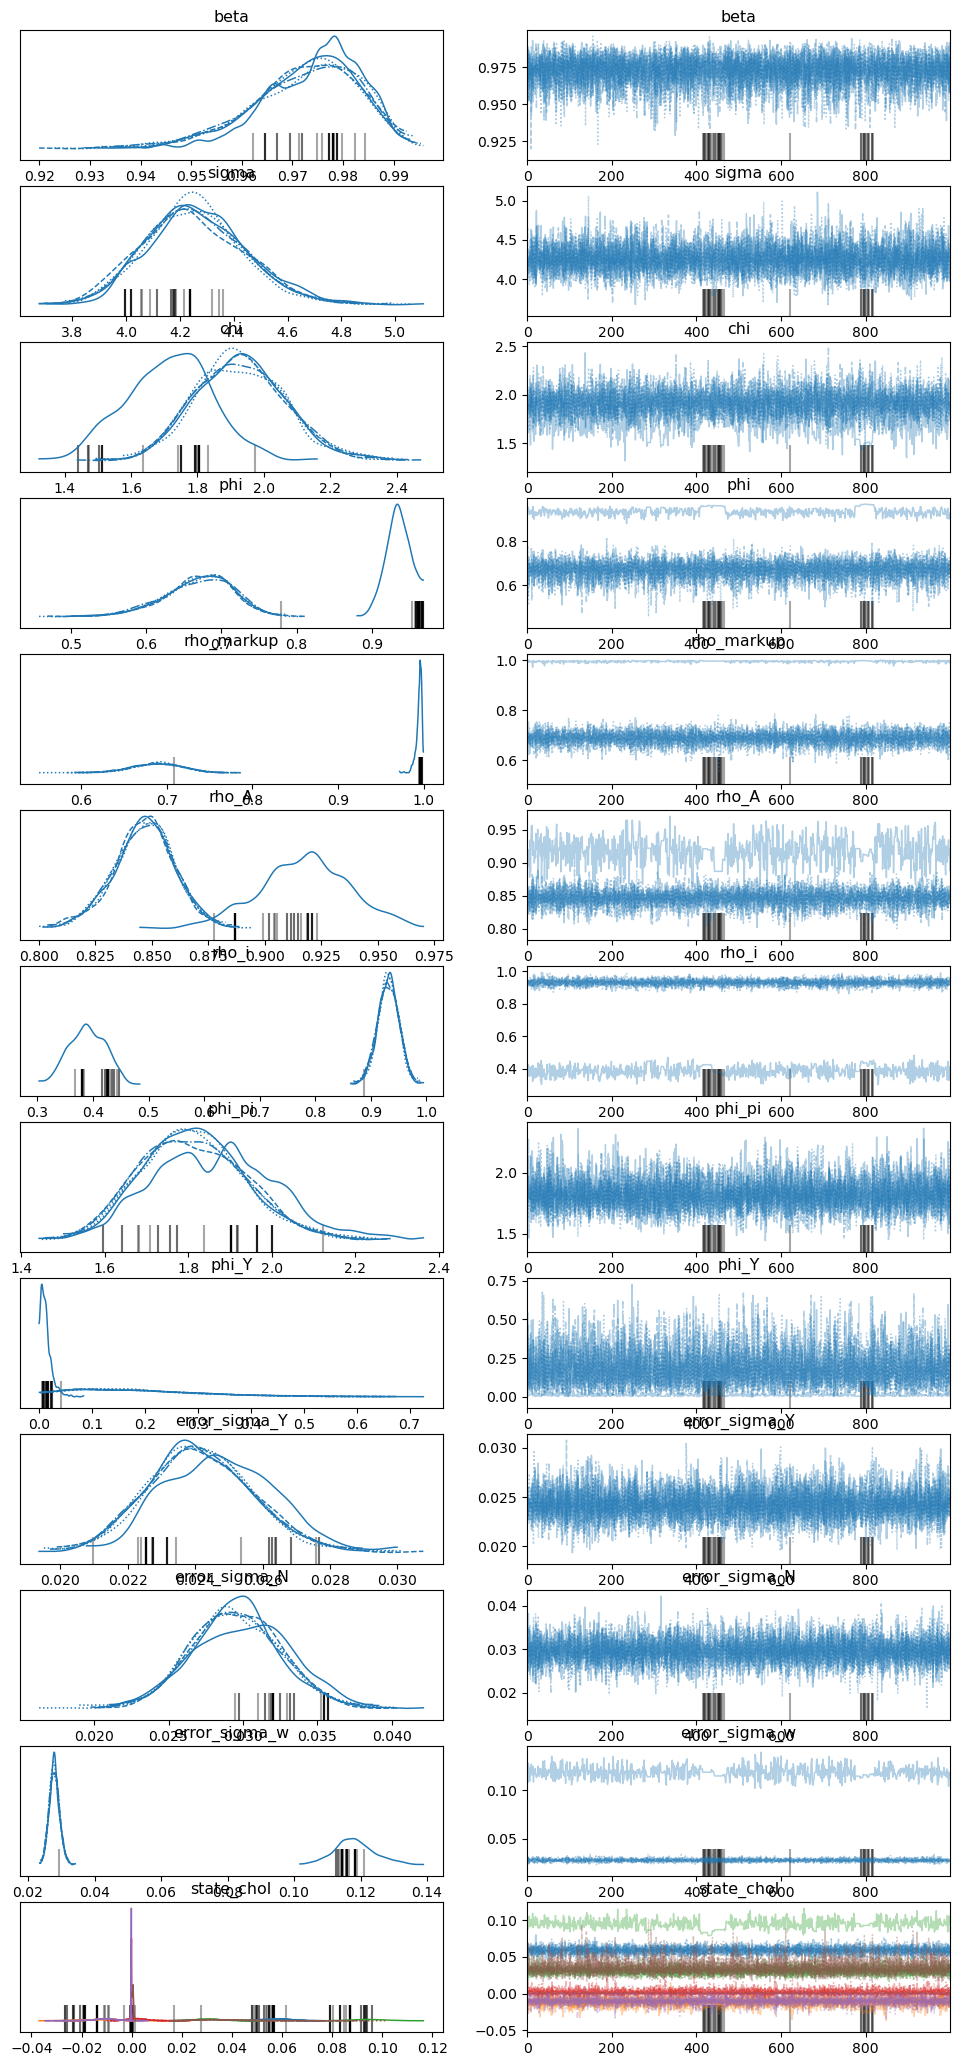

In [46]:
import arviz as az

var_names = [rv.name for rv in pm_mod.free_RVs]
az.plot_trace(idata, var_names=var_names);

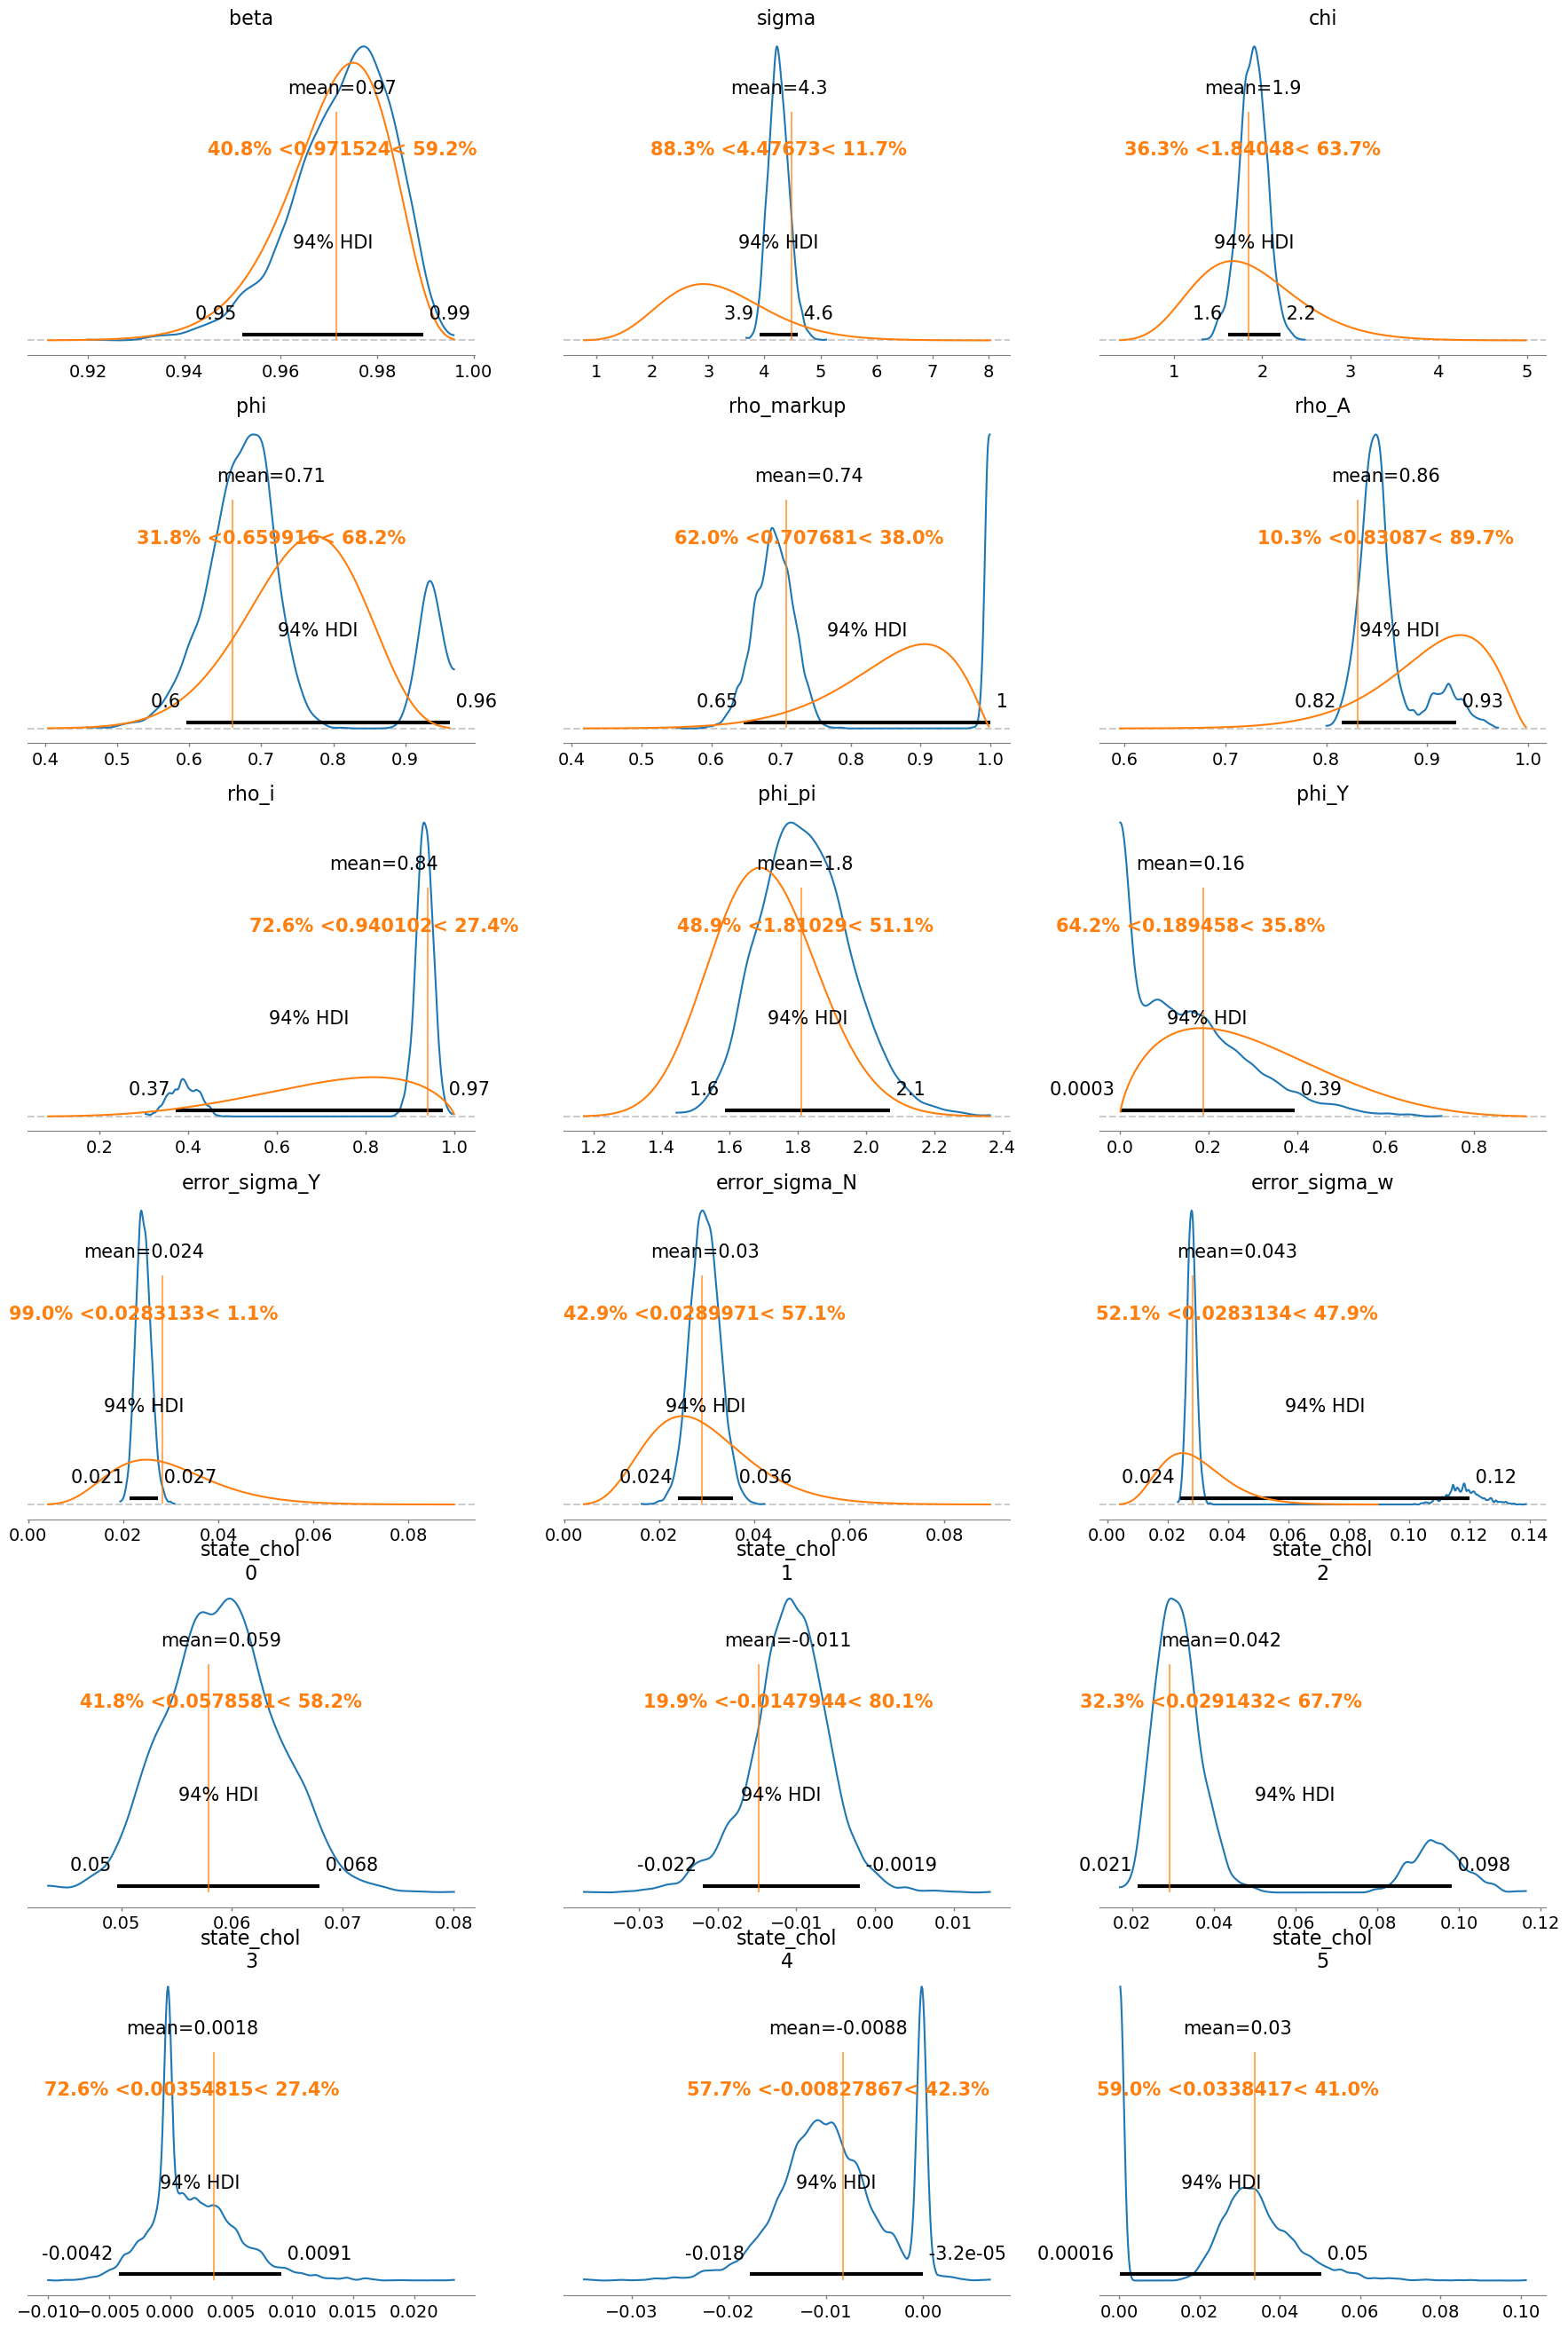

In [47]:
axes = az.plot_posterior(
    idata,
    var_names=var_names,
    ref_val=np.r_[*[true_params[name].values.ravel() for name in var_names]].tolist(),
)
for axis in axes.ravel():
    var_name, *coords = axis.get_title().split("\n")

    if var_name in all_priors:
        all_priors[var_name].plot_pdf(ax=axis, legend=False, color="tab:orange")